# Mini-Pset: Monte Carlo Tree Search for Collaboration

The pset will introduce the fundamentals of MCTS to you. The execution of a problem may take several minutes (though the implementation is easy and we provide a lot of useful hints), so start early and do not wait until the last second.

First import some utilities

In [1]:
%matplotlib inline
import math
import random 
import time
from state import AbstractState as State, AbstractAction as Action
from node import Node
from gomoku_example import *
from maze_unfinished import *
from maze_example import *

# Part 1: Introduction to MCTS

### Structure of this Mini-Pset
In the first part, you will be asked to finish the MCTS algorithm, where necessary utility functions and classes have been created but the four key steps are still waiting your implementation. After validating your code, you can see how your algorithm helps build a Gomoku AI!

In the second part, you will practice modeling a collaborative reward-collection problem using the algorithm you have implemented in the first part.

### MCTS Algorithm 

### AlphaGo Zero

### Gomoku Game


## Implementation of MCTS

We have provided a Gomoku game which is still in progress, as shown below. The black is at great advantage, and your job is to help it turn advantage into victory.

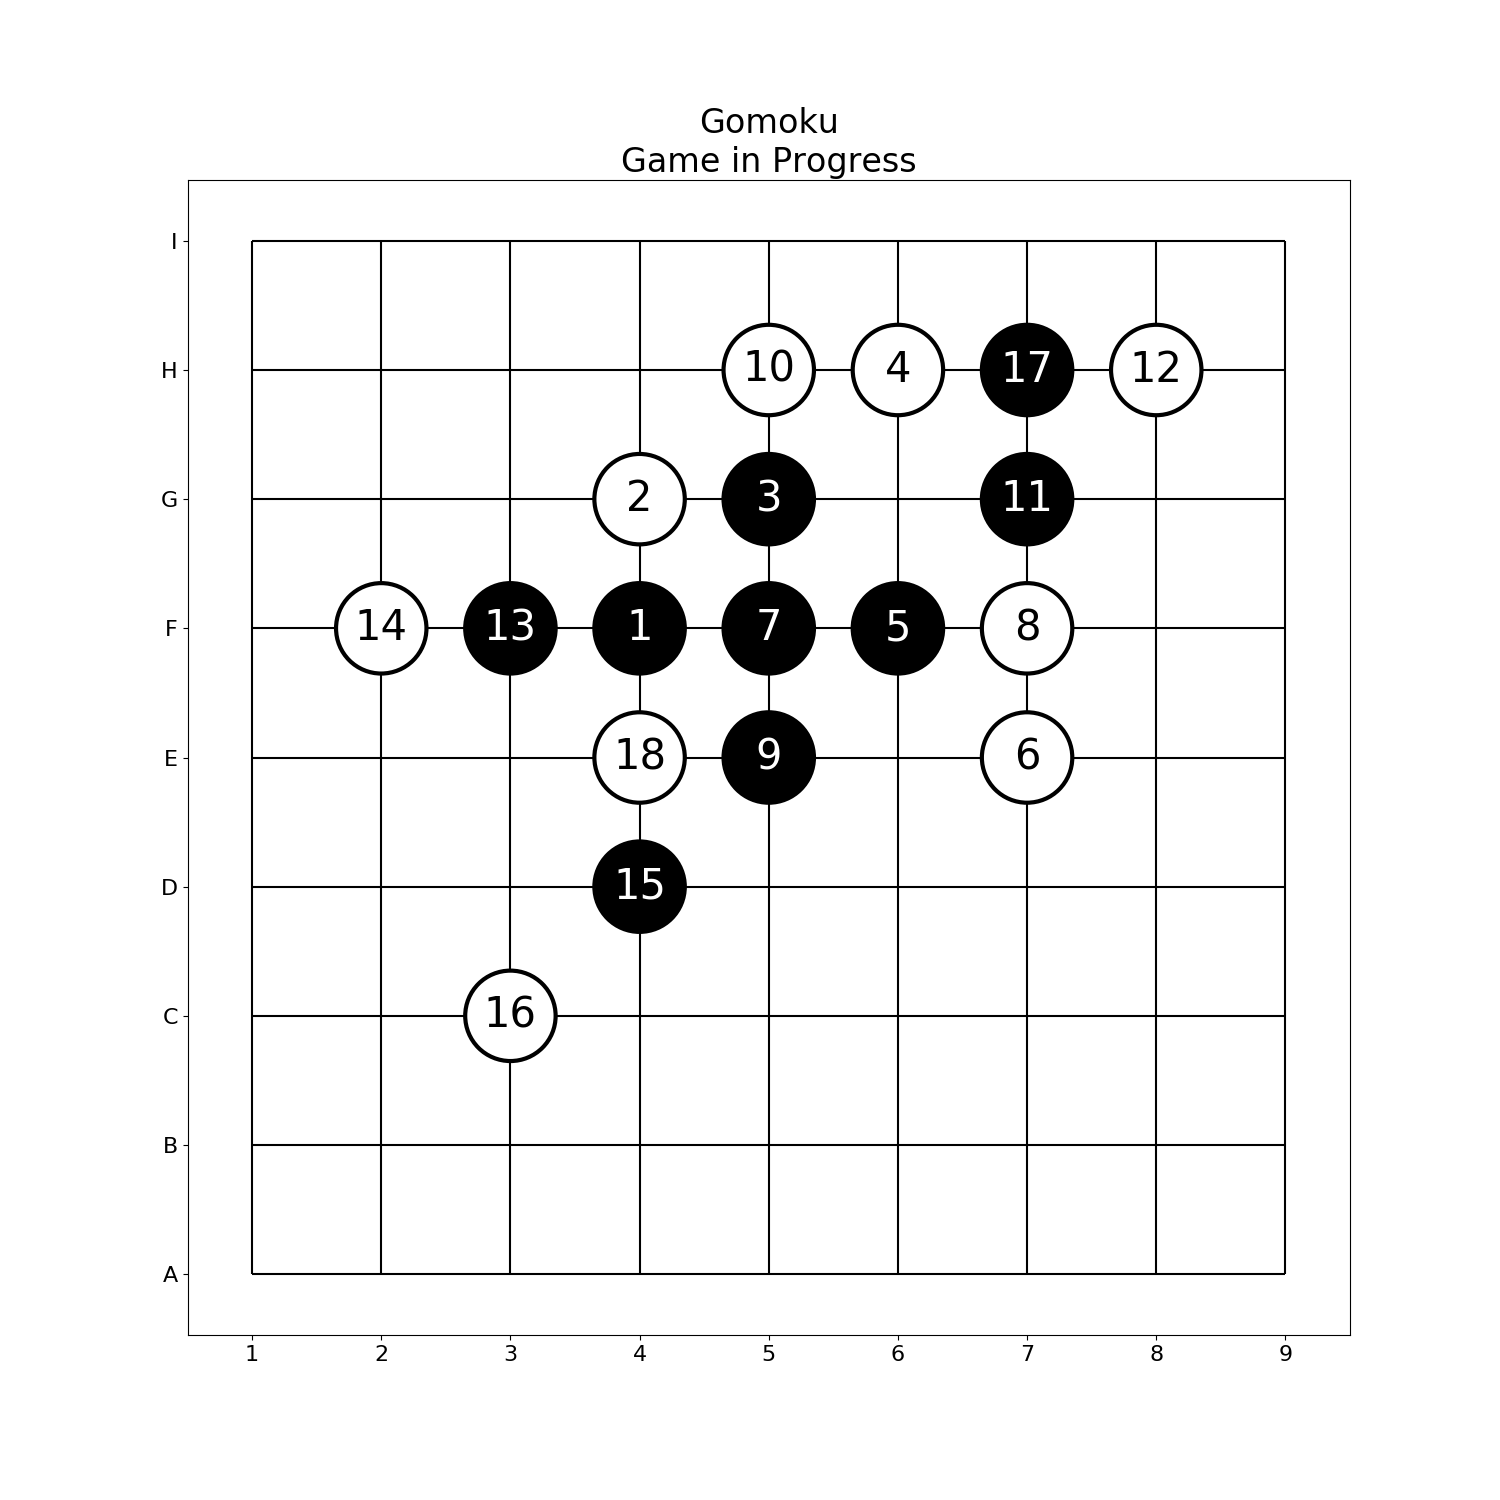

You are now asked to finish several key components in Monte Carlo Tree Search, namely the *select*, *expand*, *default_rollout_policy* and *backpropagate* functions. You will need to use the *Node* class we have defined.

A *Node* object has the following useful member variables:
1. *children*: a dictionary that maps Action objects to Node objects
1. *tot_reward*: a float of reward that has been back-propagated to this node
1. *num_samples*: an int of number of samples that has been back-propagated to this node

the following properties:
1. *state*: a State object that corresponds to the node
1. *parent*: a Node object that is the parent
1. *unused_edges*: a list of Action objects that have not contributed to building child nodes
1. *is_terminal*: a bool representing whether or not the State object associated with the node is a terminal state
1. *depth*: an int of the depth of the node. The depth of a root node, which has *None* as its parent, is 1.
1. *is_expanded*: a bool representing whether all possible actions and associated child nodes have been added to the *children* dictionary

and the following method:
1. *add_child*(*action*): if the action is in the list *unused_edges*, then build a *Node* object *child* and add *action*: *child* to *children*, and return the *child* node

When making random selection from a list of variables, use the *random.choice* function.



## Implementation: *Selection* (10 points)

Selecting which node to expand is based on choosing the node with the maximal upper confidence bound (UCB):
$$UCB=\frac{\text{reward}}{\text{number of samples of the child node}}+\sqrt{2\frac{\ln({\text{number of samples of the parent node})}}{\text{number of samples of the child node}}}$$
where the first term is the average reward per sample and is the exploitation term; the second term, coming from Hoeffding's inequality, will favor less unexplored choices and is the exploration term.

Later when we are choosing the best strategy (not in simulation), we need to choose the action that brings the maximal reward instead of UCB, so a good practice in implementation is to make the second term vanishable:
$$UCB=\frac{\text{reward}}{\text{number of samples of the child node}}+exploration\_const*\sqrt{2\frac{\ln({\text{number of samples of the parent node})}}{\text{number of samples of the child node}}}$$

In [10]:
def select(node: Node, exploration_const: float = 1.0) -> (Action, Node):
    """ Select the best child node based on UCB; if there are multiple
        child nodes with the same max UCB, randomly select one
    :param node: The parent node
    :param exploration_const: The exploration constant in UCB formula
    :return: The action and the corresponding child node it leads to
    """
    best_ucb = -math.inf
    best_actions = []
    for action, child in node.children.items():
        
        # ========================= #
        # Insert your code here
        for action, child in node.children.items():
            node_ucb = (child.tot_reward / child.num_samples
                        + exploration_const *
                        math.sqrt(2.0 * math.log(node.num_samples) /
                                  child.num_samples))
            if node_ucb > best_ucb:
                best_ucb = node_ucb
                best_actions = [action]
            elif node_ucb == best_ucb:
                best_actions.append(action)
        # ========================= #
        
    best_action = random.choice(best_actions)
    return best_action, node.children[best_action]

## Implementation: *Expansion* (10 points)
Suppose you have selected a node and that node is not a terminal node, you need to randomly select an action from the list of available untaken actions, add the associated new child node to the *children* dictionary and return the child node.

Hint: use the functions provided above.

In [3]:
def expand(node: Node) -> Node:
    """ Randomly select an untried action and create a child node based on it
        Return the new child node
    :param node: The parent node
    :return: The child node
    """
    if node.is_expanded:
        raise Exception("Should not expand a node that has already"
                        " been expanded")
    
    # ========================= #
    # Insert your code here
    action = random.choice(node.unused_edges)
    return node.add_child(action)
    # ========================= #


## Implementation: *Simulation* (10 points)

The default rollout policy is to keep randomly selecting an action from the available ones until a terminal state is reached.

A *State* object has a property *is_terminal* to represent whether a it is a terminal state, another property *possible_actions* which is a list of *Action* objects, and a member method *execute_action* which takes an *Action* object as input and returns a copy of a new state.

Hint: use *random.choice* to randomly select an action from a list of actions.

In [4]:
def default_rollout_policy(state: State) -> float:
    """ The default policy for simulation is to randomly (uniform distribution)
        select an action to update the state and repeat the simulation until
        a terminal state is reached
    :param state: The starting state
    :return: The reward at the terminal state
    """
    
    # ========================= #
    # Insert your code here
    while not state.is_terminal:
        action = random.choice(state.possible_actions)
        state = state.execute_action(action)
    return state.reward
    # ========================= #


## Implementation: *Back Propagation* (10 points)
After simulation is performed, the next thing is to update the visit counts and rewards for relevant nodes.

Hint: *Node* objects have a member property *parent*; older visit count and reward are stored in public member variables *num_samples* and *tot_reward* respectively.

In [5]:
def backpropagate(node: Node, reward: float = 0.0) -> None:
    """ Propagate the reward and sample count from the specified node
        back all the way to the root node (the node with None as parent)
    :param node: The node wheresimulation is performed and
        the reward is evaluated
    :param reward: The reward at the node
    """
    
    # ========================= #
    # Insert your code here
    while node is not None:
        node.num_samples += 1
        node.tot_reward += reward
        node = node.parent
    # ========================= #


## Implementation: *Execute Round*
Run the following code which combines the four functions above. We have included *max_tree_depth* to limit the size of the search tree.

In [6]:
def execute_round(root: Node, rollout_policy=default_rollout_policy,
                  max_tree_depth: int = 15) -> None:
    """ Perform selection, expansion, simulation and backpropagation
    """
    cur = root
    while cur.is_expanded and cur.depth < max_tree_depth:
        act, cur = select(cur, exploration_const=1.0)
    simulation_node = expand(cur) if max_tree_depth > cur.depth else cur
    reward = rollout_policy(simulation_node.state)
    backpropagate(simulation_node, reward)

## Implementation: *Monte Carlo Search Tree*
Run the code below to create the class of the Monte Carlo Search Tree.

In [7]:
class MonteCarloSearchTree:
    def __init__(self, initial_state: State, samples: int = 1000,
                 exploration_const: float = 1.0, max_tree_depth: int = 10,
                 rollout_policy=default_rollout_policy):
        """ Create a MonteCarloSearchTree object
        :param initial_state: The initial state
        :param samples: The number of samples to generate to obtain the best
                action
        :param exploration_const: The constant on the second term of UCB
        :param max_tree_depth: The maximal allowable number of nodes in the tree
        :param rollout_policy: The simulation function
        :type: A function that takes a state as input, perform simulation until
                a terminal state, and returns the reward of the final state
        """
        if samples <= 0 or max_tree_depth <= 1:
            raise ValueError("The number of samples must be positive")
        self._max_samples = samples
        self._exploration_const = exploration_const
        self._rollout = rollout_policy
        self._root = Node(initial_state)
        self._max_tree_depth = max_tree_depth

    def search_for_actions(self, search_depth: int = 1) -> list:
        """ With given initial state, obtain the best actions to take by MCTS
        :param search_depth: How many steps of actions are wanted
        :return: The best actions
        :rtype: A list of AbstractAction objects
        """
        for _ in range(self._max_samples):
            execute_round(self._root, max_tree_depth=self._max_tree_depth)
        actions = []
        cur_node = self._root
        for _ in range(search_depth):
            if cur_node.is_terminal:
                break
            else:
                action, child = select(cur_node, exploration_const=0.0)
                cur_node = child
                actions.append(action)
        return actions

    def update_root(self, action: Action) -> "MonteCarloSearchTree":
        """ Update the root node to reflect the new state after an action is
            taken
        :param action: The action that brings a new state
        """
        if action in self._root.children:
            new_root = self._root.children[action]
        else:
            new_root = self._root.add_child(action)
        self._root.remove_child(new_root)
        self._root = new_root
        return self

## Written Question: *MCTS with Heuristics* (10 points)
Now you have implemented the MCTS algorithm, you should be ready to use it run it on the Gomoku problem. Note that the execution might take 3-5 minutes. To ensure that the simulation always terminates in a reasonable number of steps and to make sure that the results observed by everyone are similar, we have fixed the random seed.

Action (player BLACK takes position (3, 7))
Action (player WHITE takes position (2, 3))
Action (player BLACK takes position (2, 6))
Action (player WHITE takes position (5, 3))
Action (player BLACK takes position (3, 0))
Action (player WHITE takes position (4, 2))
Action (player BLACK takes position (0, 8))
Action (player WHITE takes position (1, 7))
Action (player BLACK takes position (1, 0))
Action (player WHITE takes position (6, 2))
Action (player BLACK takes position (8, 7))
Action (player WHITE takes position (2, 0))
Action (player BLACK takes position (0, 2))
Action (player WHITE takes position (3, 1))


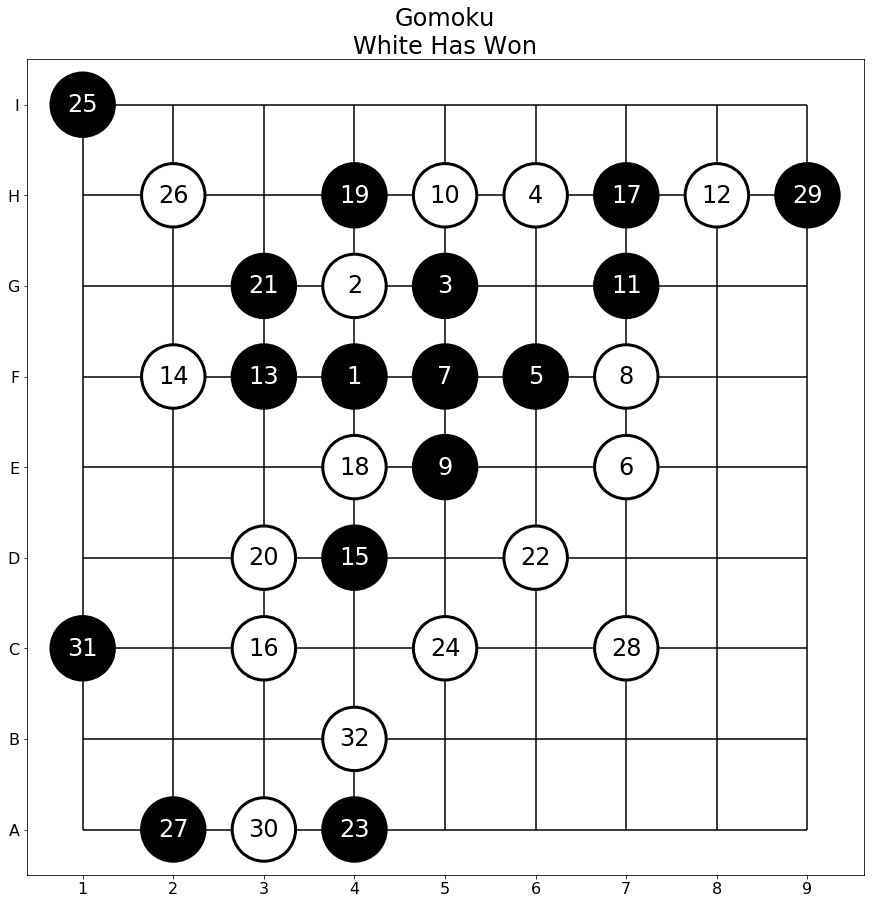

In [8]:
simulate_with_black_sample_arbitrarily(MonteCarloSearchTree)

Does the result look good? Start thinking about why (you do not need to answer it right now).

In the simulation conducted above, the MCTS algorithm, at each step, simply randomly select an unoccupied position as the next move. However, there can be heuristics involved. In the next simulation, the algorithm will only consider positions with at least one occupied neighbor (so positions with no neighborhood occupied always has a probability of 0 in rollout).

Action (player BLACK takes position (5, 3))
Action (player WHITE takes position (6, 3))
Action (player BLACK takes position (6, 2))
Action (player WHITE takes position (5, 2))
Action (player BLACK takes position (2, 6))


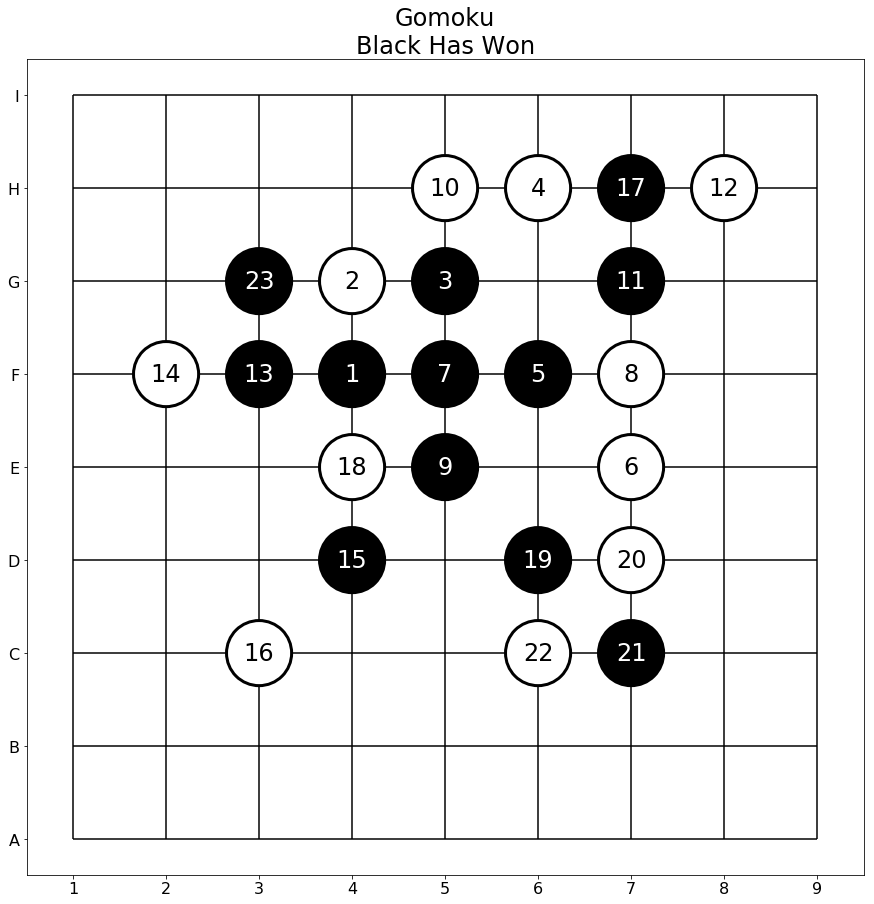

In [9]:
simulate_with_black_sample_neighborhood(MonteCarloSearchTree)

Which strategy generates a better result? Explain why. Could you come up with some potential methods to improve the performance of MCTS in Gomoku games?

<font color='darkgreen'>ENTER YOUR ANSWER HERE.</font>

# Part 2: MCTS for Collaboration
In part 1, you have implemented the MCTS algorithm; in part 2, you will learn how to model a problem to call that algorithm.

### AUV Reward Collection Problem
Suppose you are given 3 AUVs and your task is to use them to explore valuable locations of an underwater area, which has been spatially discretized below:

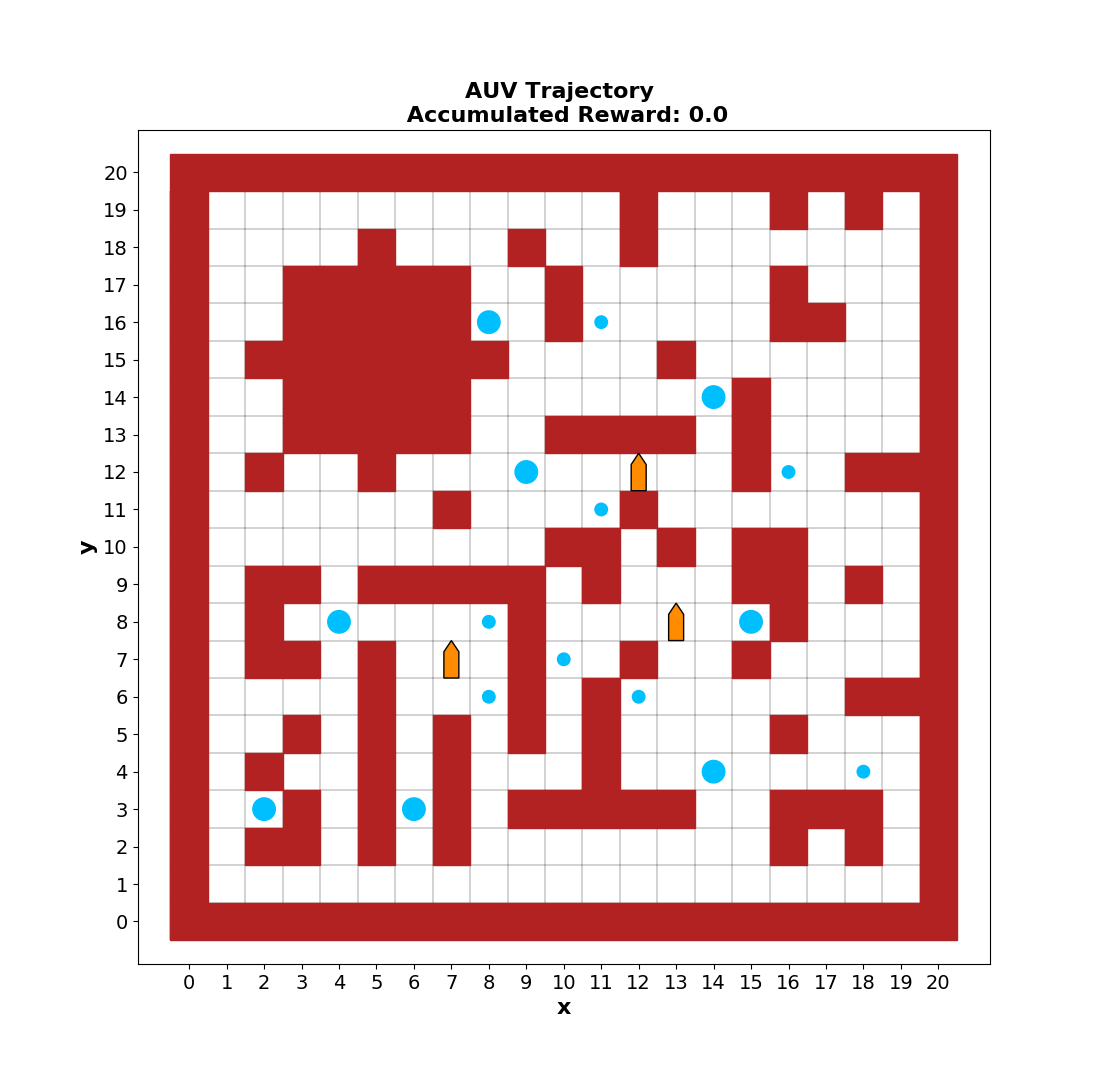

The time is also discretized into 15 steps. At each time step, an AUV can move to one of the 4 neighboring locations as long as it is not an obstacle (the red blocks in the figure). The radius of blue circles represent the information values of different locations: the larger radius corresponds to 3, and the smaller represents 1.

We refer to this example as Maze Example 1. The task is to model this problem so the algorithm developed in Part 1 can be applied (and how the Gomoku games are implemented is quite similar).

## Implementation: *Reward*, *is_terminal*, *possible_actions*, *take_action* (10 points each)


We have provided a class *UnfinishedMazaState*, and your job is to finish building the class *MazeState*. To be more specific, you need to implement 4 key properties/methods, namely *is_terminal*, *reward*, *possible_actions* and *take_action*. You may find the following information useful.

A *MazeAction* object
1. Can be constructed using *MazeAction(agent_index: int, position: (int, int)*, where *agent_index* indicates which AUV should move, and position is a tuple representing where it is moving to
1. Has properties *agent_index* and *position*

A *MazeEnvironment* object
1. Has property *rewards*, whcih is a dictionary mapping position (int, int) to reward value (float)
2. Has property *obstacles*, which is a set of position (int, int)

An *UnfinishedMazeState* object
1. Has a method *is_in_range* that takes (int, int) as input and returns a bool, indicating whether a position is inside the problem domain
1. Has a property *paths* - \[*path_0*, *path_1*, *path_2*, $\ldots$\]. Each *path_i* is a list of position tuples (int, int); the last tuple is current position of agent $i$. This records the trajectories of all agents
1. Has a property *time_remains* which is an int object
1. Has a property *visited* which is a set of visited position tuples (int, int)
1. Has a property *turn* - an int object indicating which agent should move
1. Has a property *switch_agent* which will properly update *turn* so the next agent can move; if all agents have moved for a round, then the *time_remains* property would be updated
1. Has a property *environment*, which is a *MazeEnvironment* object


In [ ]:
class MazeState(UnfinishedMazeState):

    def __init__(self, environment: MazeEnvironment, time_remains: int = 10):
        """ Create a state of the AUV reward-collection game
        """
        super(UnfinishedMazeState, self).__init__(environment, time_remains)

    @property
    def reward(self) -> float:
        """ The total reward at the current state is value of
            rewards that have been visited by agents
        """
        
        # ========================= #
        # Insert your code here
        # ========================= #
        pass
        
    @property
    def is_terminal(self) -> bool:
        """ The only terminal condition is no time remains
        """
        
        # ========================= #
        # Insert your code here
        # ========================= #
        pass
        
    @property
    def possible_actions(self) -> list:
        """ The possible actions based on the current state
            Note that you are only moving a single agent
        """
        
        # ========================= #
        # Insert your code here
        # ========================= #
        pass
        
    def take_action(self, action: MazeAction) -> "MazeState"
        """ Execute the action based on the current state
            You can assume that the action is always valid
        :param action: The action
        :return: The state after being updated
        """
        
        # ========================= #
        # Insert your code here
        # ========================= #
        return self
    

After your code is validated, you can run the simulation. Note that the simulation would take several minutes and we have fixed the random seed.

In [ ]:
simulate(maze_example_1()).visualize()

## Written Question: *Limitations of MCTS* (10 points)
Now you will run simulation on a different environment as shown below

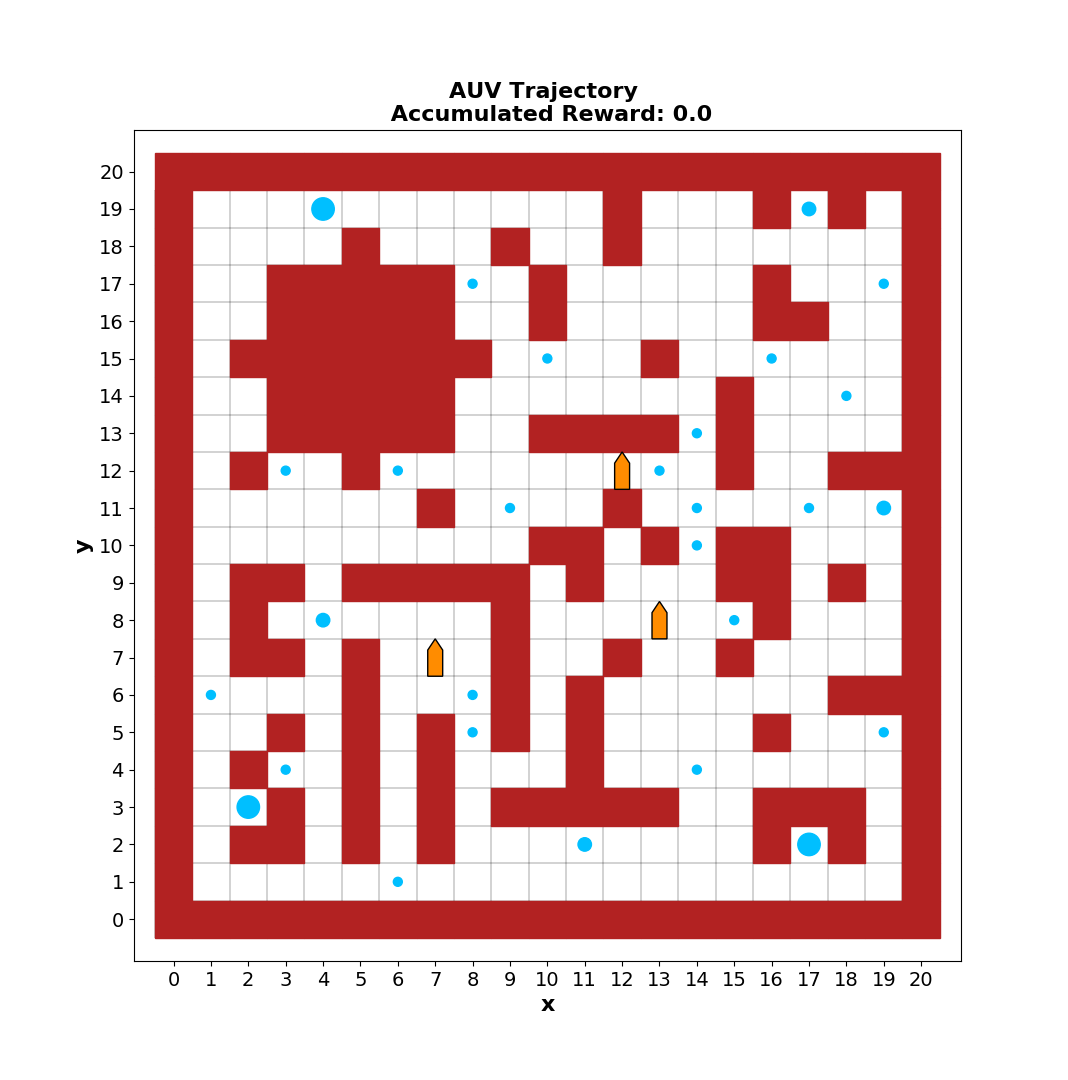

The largest radius now has reward value 10, the smallest has 1 and the intermediate has 4. Other rules remain unchanged (you still have 15 time steps).

### Question 1 (3 points)
What is the optimal strategy? You only need to conceptually describe it. There is no need to enter the exact moves for each time steps.

For example:
> The AUV starting at (13, 8) should first collect the reward at (14, 10), (14, 11), and then move towards the reward at (15, 8)
> The AUV starting at (7, 7) should move towards the reward at (11, 2)
> The AUV starting at (12, 12) should move towards the reward at (4, 19)

<font color='darkgreen'>ENTER YOUR ANSWER HERE.</font>

Now, run the simulation. The execution will again take several minutes.

In [ ]:
simulate(maze_example_2()).visualize()

<font color='darkgreen'>ENTER YOUR ANSWER HERE.</font>